基于自相关函数的标准化功率谱估计方法,理论依据如下所示：

$$
S_{X}(f)=\int_{-\infty}^{+\infty} r_{X}(\tau) e^{-i 2 \pi f \tau} d \tau=2 \int_{0}^{+\infty} r_{X}(\tau) \cos 2 \pi f \tau d \tau
$$


这里使用的数据为climate prediction center的nino34指数，数据下载网址为：
- https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt

其他一些海洋气象的指数下载可以在以下网址找到：

- https://psl.noaa.gov/gcos_wgsp/Timeseries/Nino34/

导入工具包

In [4]:


from scipy.signal import find_peaks
from scipy.stats import chi2
import matplotlib.ticker as ticker
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import pandas as pd
from matplotlib import gridspec
from matplotlib.colors import ListedColormap 
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import os
import glob
from datetime import datetime, timedelta
import cmaps
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cftime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches
from scipy.signal import detrend


读取数据，并去除趋势

In [5]:


###############################################################################
print('-----------------------------------------------------------------------')
print('----------------   read anomaly of data : nino34.txt ------------------')
print('-----------------------------------------------------------------------')
path = r'I:/nino34.ascii.txt'

# 假设文件的第一列是要作为索引的列
df = pd.read_csv(path, sep='\s+')

print(df.head())

anom_data = df['ANOM']

# 对数据进行去趋势处理
x_detrended_data = detrend(anom_data)



-----------------------------------------------------------------------
----------------   read anomaly of data : nino34.txt ------------------
-----------------------------------------------------------------------
     YR  MON  TOTAL  ClimAdjust  ANOM
0  1951    1  25.26       26.18 -0.92
1  1951    2  25.72       26.39 -0.66
2  1951    3  26.91       26.95 -0.04
3  1951    4  27.59       27.39  0.20
4  1951    5  27.93       27.56  0.37


<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
C:\Users\jixianpu\AppData\Local\Temp\ipykernel_82768\2558734989.py:8: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(path, sep='\s+')


计算自相关系数
这里测试了两种算法，差距不大

-----------------------------------------------------------------------
----------------   calculate auto correlation of x --------------------
-----------------------------------------------------------------------
the length of time serise: 804
max_lag number is : 201
-----------------------------------------------------------------------
-------------- plot two methods results of autocorrelation ------------
-----------------------------------------------------------------------


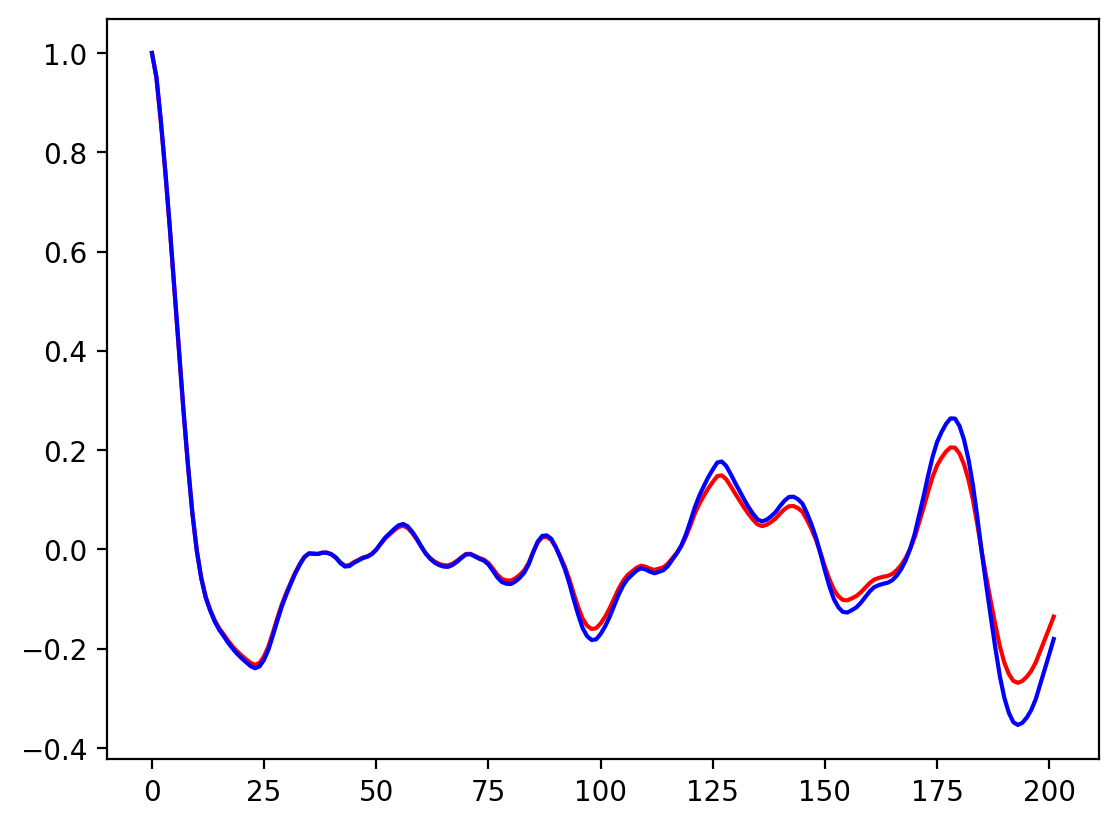

In [6]:


###############################################################################
print('-----------------------------------------------------------------------')
print('----------------   calculate auto correlation of x --------------------')
print('-----------------------------------------------------------------------')
n  = len(x_detrended_data)
print('the length of time serise:',n)
m = n // 4
print('max_lag number is :',m)

def autocorrelation1(x,m):
    n = len(x)
    mean_x = np.mean(x)
    variance = np.sum((x - mean_x) ** 2)
    r = np.zeros(m + 1)

    for j in range(m + 1):
        r[j] = np.sum((x[:n-j] - mean_x) * (x[j:] - mean_x)) / variance

    return r

def autocorrelation2(x, max_lag):
    """
    计算样本时间序列的自相关系数
    
    参数:
    x (numpy array): 时间序列数据
    max_lag (int): 最大滞后数，一般建议取为 n/3 到 n/10
    
    返回:
    autocorr (numpy array): 各滞后数下的自相关系数数组
    """
    n = len(x)
    mean_x = np.mean(x)  # 均值
    s = np.std(x, ddof=0)  # 标准差

    autocorr = np.zeros(max_lag + 1)  
    
    for j in range(max_lag + 1):
        autocorr[j] = np.sum((x[:n-j] - mean_x) * (x[j:] - mean_x)) / ((n - j) * s**2)
        
    return autocorr

# 示例数据
r_values1 = autocorrelation1(x_detrended_data,m)

r_values2 = autocorrelation2(x_detrended_data, max_lag=m)
print('-----------------------------------------------------------------------')
print('-------------- plot two methods results of autocorrelation ------------')
print('-----------------------------------------------------------------------')
plt.figure(dpi=200)

plt.plot(r_values1,'r',label='method1')
plt.plot(r_values2,'b',label='method2')


计算粗谱

-----------------------------------------------------------------------
----------------   calculate  raw power spectra -----------------------
-----------------------------------------------------------------------


(-0.02, 0.14)

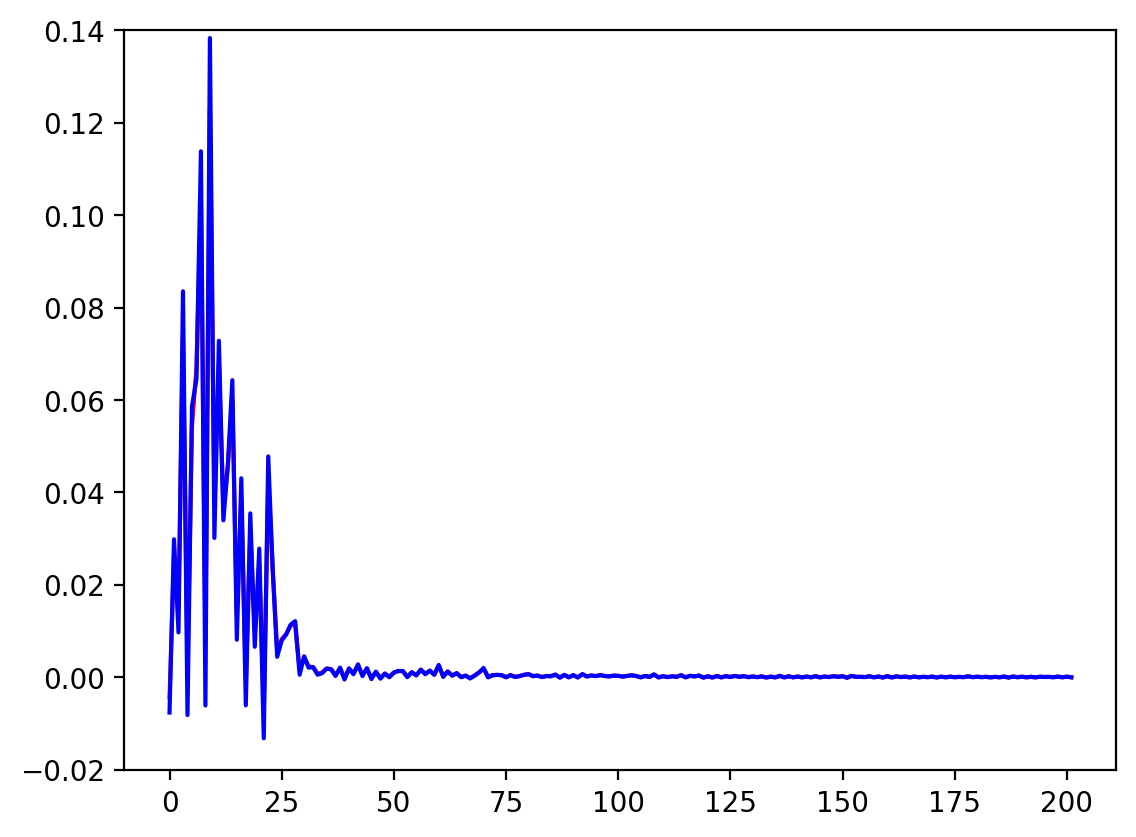

In [7]:


print('-----------------------------------------------------------------------')
print('----------------   calculate  raw power spectra -----------------------')
print('-----------------------------------------------------------------------')

def compute_spectrum(autocorr, m):
    """
    计算粗谱
    
    参数:
    autocorr (numpy array): 自相关系数数组，长度为 m+1
    m (int): 最大滞后数
    
    返回:
    spectrum (numpy array): 粗谱数组，包含 k=0 到 k=m 的粗谱值
    """
    spectrum = np.zeros(m + 1)

    # 计算 S_0 (k=0)
    spectrum[0] = (1 / (2 * m)) * (autocorr[0] + autocorr[m]) + (1 / m * np.sum(autocorr[1:m]))

    # 计算 S_k (1 <= k <= m-1)
    for k in range(1, m):
        sum_term = np.sum([autocorr[j] * np.cos(k * np.pi * j / m) for j in range(1, m)])
        spectrum[k] = (1 / m) * (autocorr[0] + 2 * sum_term + (-1)**k * autocorr[m])

    # 计算 S_m (k=m)
    sum_term_m = np.sum([(-1)**j * autocorr[j] for j in range(1, m)])
    spectrum[m] = (1 / (2 * m)) * (autocorr[0] + (-1)**m * autocorr[m]) + (1 / m * sum_term_m)

    return spectrum

spe1 = compute_spectrum(r_values1, m)
spe2 = compute_spectrum(r_values2, m)

plt.figure(dpi=200)
plt.plot(spe1,'r',label='method1')
plt.plot(spe2,'b',label='method2')
plt.ylim(-0.02,0.14)

计算平滑谱

-----------------------------------------------------------------------
-------------------   smoothing   power spectra -----------------------
-----------------------------------------------------------------------


(-0.02, 0.14)

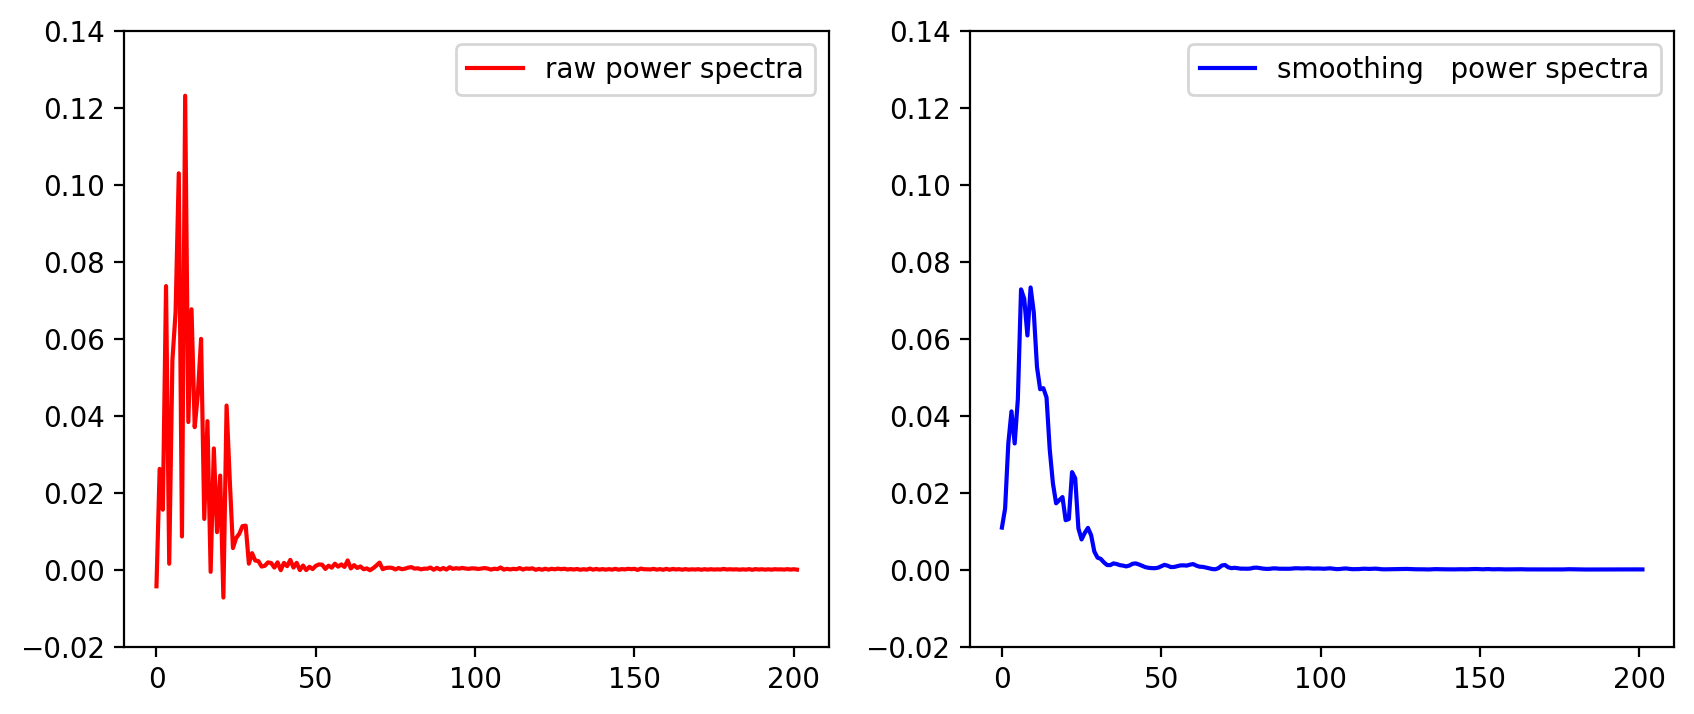

In [8]:


print('-----------------------------------------------------------------------')
print('-------------------   smoothing   power spectra -----------------------')
print('-----------------------------------------------------------------------')


def hanning_smoothing(spectrum):
    """
    对粗谱进行 Hanning 平滑处理

    参数:
    spectrum (numpy array): 粗谱数组，包含 k=0 到 k=m 的粗谱值

    返回:
    smoothed_spectrum (numpy array): 平滑后的谱数组
    """
    m = len(spectrum) - 1
    smoothed_spectrum = np.zeros(m + 1)

    # 计算 S_0
    smoothed_spectrum[0] = 0.5 * spectrum[0] + 0.5 * spectrum[1]

    # 计算 S_k (1 <= k <= m-1)
    for k in range(1, m):
        smoothed_spectrum[k] = 0.25 * spectrum[k-1] + 0.5 * spectrum[k] + 0.25 * spectrum[k+1]

    # 计算 S_m
    smoothed_spectrum[m] = 0.5 * spectrum[m-1] + 0.5 * spectrum[m]

    return smoothed_spectrum

# 示例用法
# 示例粗谱值
smoothed_values = hanning_smoothing(spe1)

plt.figure(dpi=200,figsize=(10,4))
plt.subplot(121)
plt.ylim(-0.02,0.14)
plt.plot(spe1,'r',label='raw power spectra')
plt.legend()
plt.subplot(122)
plt.plot(smoothed_values,'b',label='smoothing   power spectra')
plt.ylim(-0.02,0.14)
plt.legend()
plt.ylim(-0.02,0.14)

计算频率周期

In [9]:

print('-----------------------------------------------------------------------')
print('-----------------   calculate frequency and period --------------------')
print('-----------------------------------------------------------------------')

def compute_frequency_and_period(m):
    # 确定频率和周期 
    # 虽然k=0,1,2,3,...,m .但是由于python左闭右开的原因，这里m+1
    frequencies = np.array([k / (2 * m) for k in range(m + 1)])
    periods = np.array([2 * m / k if k != 0 else np.inf for k in range(m + 1)])  # 防止 k = 0 的情况
    return frequencies, periods


fre,per = compute_frequency_and_period(m)

-----------------------------------------------------------------------
-----------------   calculate frequency and period --------------------
-----------------------------------------------------------------------


计算显著性检验

-----------------------------------------------------------------------
----------- statistical significence of power spectra -----------------
-----------------------------------------------------------------------
mean_S.shape: 0.00498600571431811
red_noise.shape: (202,)
white_noise.shape: (202,)


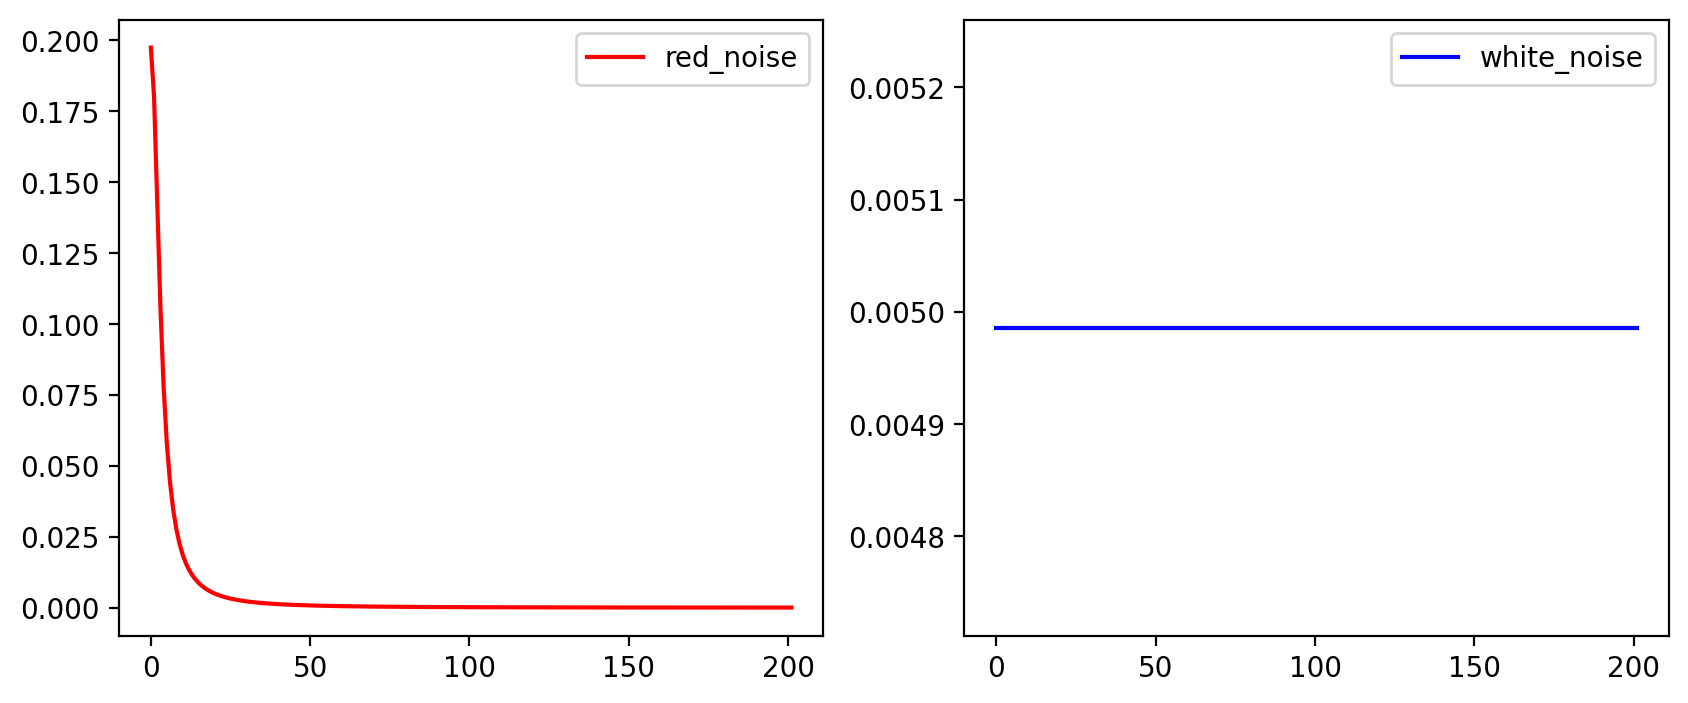

In [10]:

print('-----------------------------------------------------------------------')
print('----------- statistical significence of power spectra -----------------')
print('-----------------------------------------------------------------------')

def significance_test(S, r_1, m):
    # 显著性检验
    # mean_S 为m+1个谱估计值的均值
    """
    numpy.fromiter(iter, dtype, count=-1, *, like=None)
    Create a new 1-dimensional array from an iterable object.
    """

    mean_S = (1 / (2 * m)) * (S[0] + S[m]) + (1 / m) * np.sum(np.fromiter((S[k] for k in range(1, m)), float))
    print('mean_S.shape:',mean_S)
    red_noise = np.array([(1 - r_1[1]**2) / (1 + r_1[1]**2 - 2 * r_1[1] * np.cos(np.pi * k / m)) * mean_S for k in range(m + 1)])
    print('red_noise.shape:',red_noise.shape)
    white_noise = np.full(m + 1, mean_S)
    print('white_noise.shape:',white_noise.shape)
    return red_noise, white_noise, mean_S

red_noise, white_noise, mean_S = significance_test(smoothed_values, r_values1, m)

plt.figure(dpi=200,figsize=(10,4))
plt.subplot(121)
plt.plot(red_noise,'r',label='red_noise')
plt.legend()
plt.subplot(122)
plt.plot(white_noise,'b',label='white_noise')
plt.legend()

绘图

-----------------------------------------------------------------------
-------------------- plot result of power spectra ---------------------
-----------------------------------------------------------------------
Peak periods: [11.16666667  5.58333333  3.72222222  2.57692308  1.76315789  1.52272727
  1.24074074]


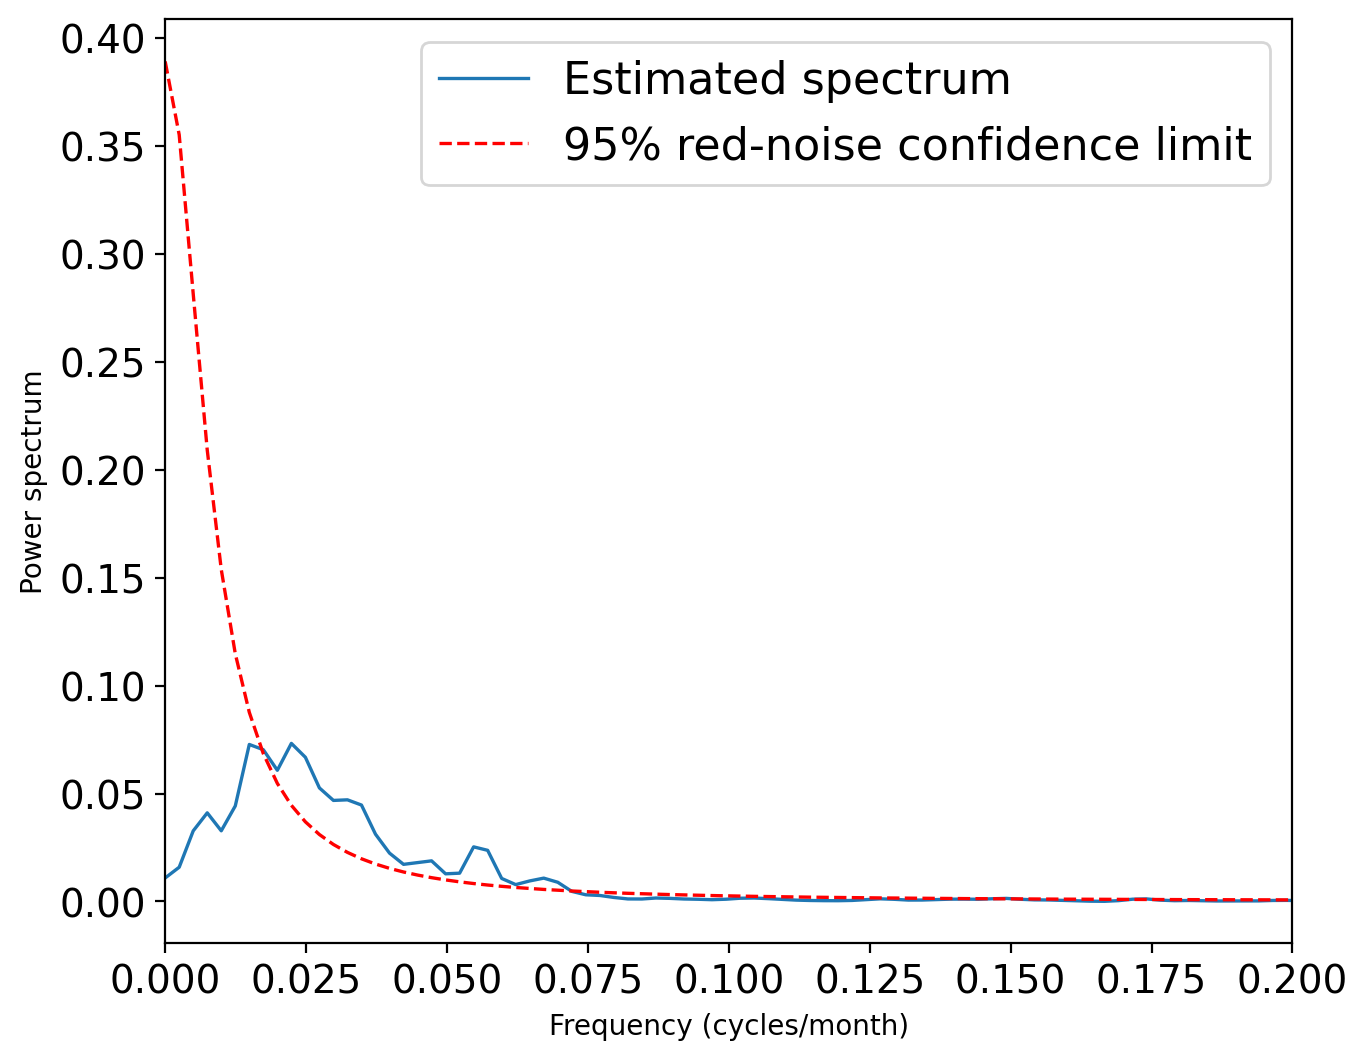

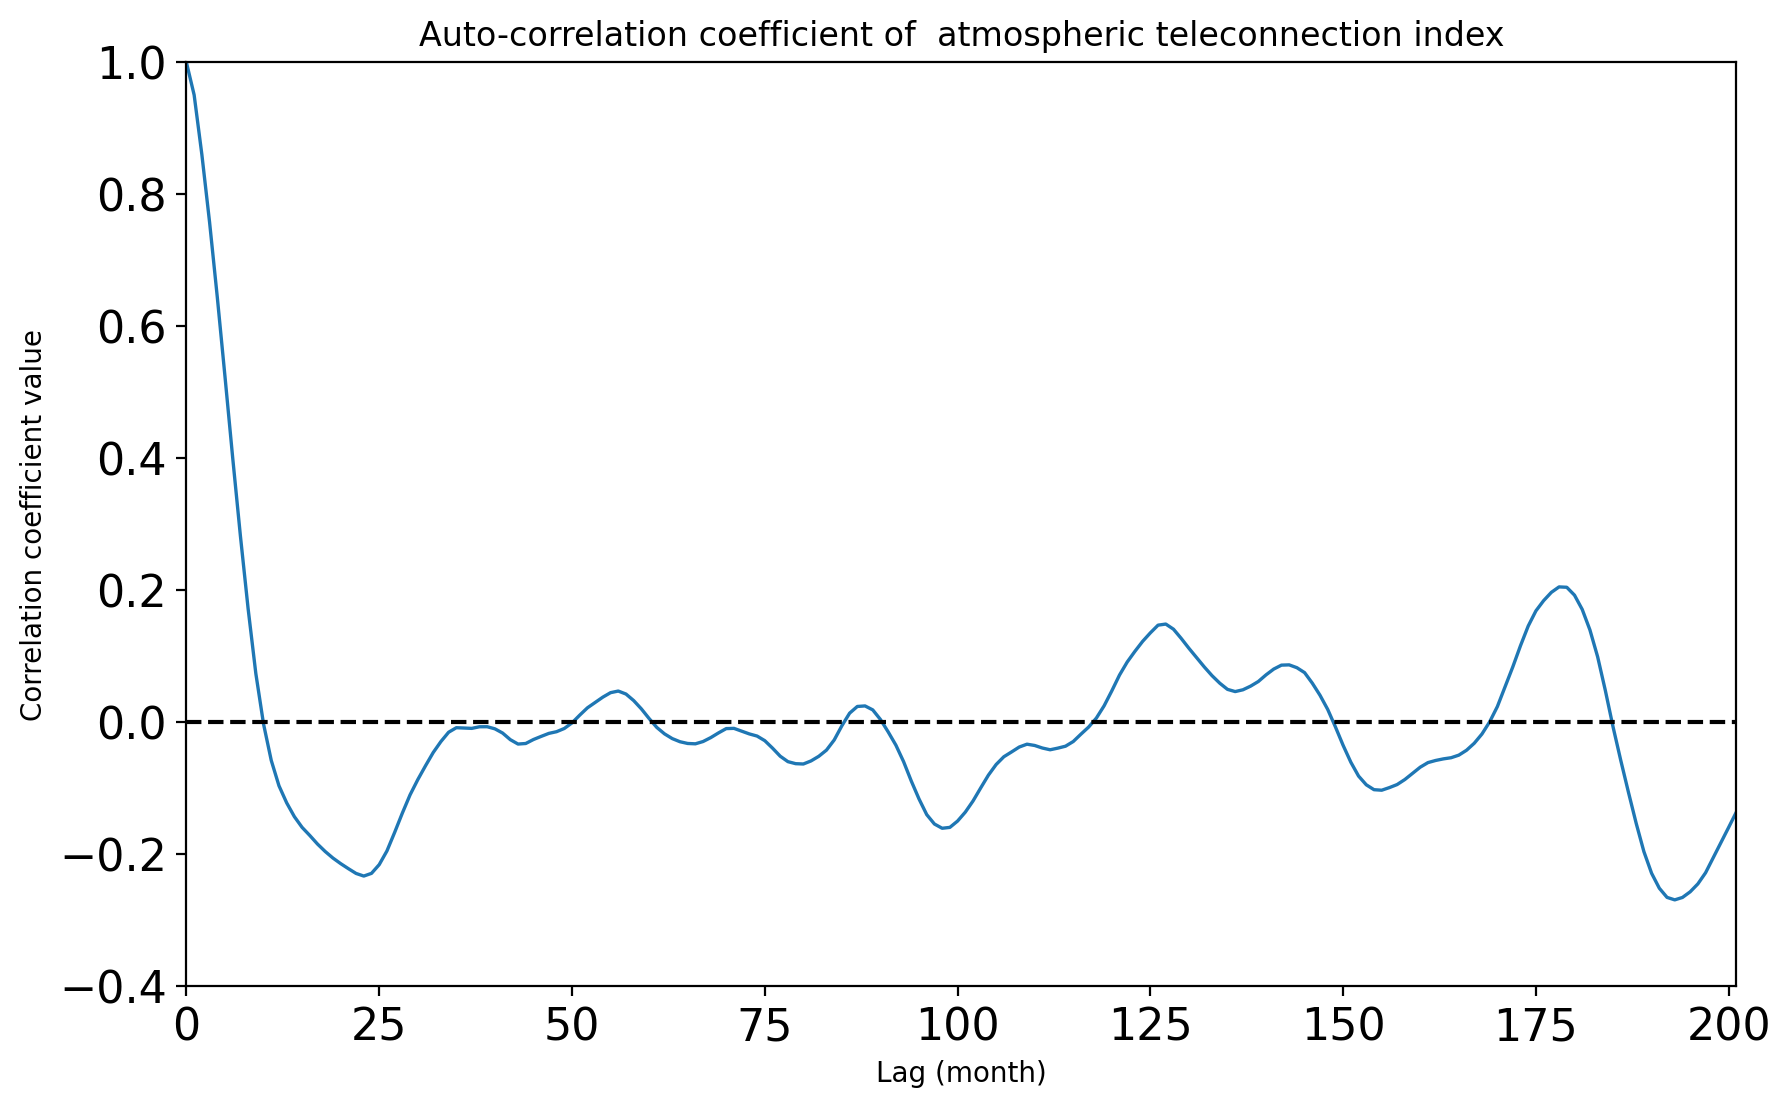

In [11]:

print('-----------------------------------------------------------------------')
print('-------------------- plot result of power spectra ---------------------')
print('-----------------------------------------------------------------------')

Density  = smoothed_values
v        = (2*n-m/2)/m
CL95_red = red_noise*chi2.ppf(1 - 0.05, v) / v

plt.figure(figsize=(16, 6),dpi=200)
plt.subplot(121)
plt.plot(fre, Density, '-', linewidth=1.2, label='Estimated spectrum')
plt.plot(fre, CL95_red, '--r', linewidth=1.2, label='95% red-noise confidence limit')
plt.legend(fontsize=16)
xticks = np.arange(0, 0.52, 0.025)
plt.xticks(xticks)
plt.xlabel('Frequency (cycles/month)')
plt.ylabel('Power spectrum')
plt.gca().tick_params(width=0.8, labelsize=14)
plt.xlim(0,0.2)
# 查找峰值
Pks, _ = find_peaks(Density, height=0.01)
peak_periods = 1 / (fre[Pks] * 12)
print("Peak periods:", peak_periods)

plt.show()


# 绘制自相关系数图
lags = np.arange(0, m + 1)
plt.figure(figsize=(10, 6),dpi=200)
plt.plot(lags, r_values1, '-', linewidth=1.2)
plt.xlim([0, m])
plt.ylim([-0.4, 1])
plt.xlabel('Lag (month)')
plt.ylabel('Correlation coefficient value')
plt.title('Auto-correlation coefficient of  atmospheric teleconnection index')
plt.gca().tick_params(width=0.8, labelsize=16)
plt.hlines(y=0,xmin=0,xmax=202,linestyles='--',colors='k')
plt.show()
